# `Importing Libraries`

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Dataset,DataLoader,Subset,ConcatDataset
import torchvision.transforms as tt
from torchvision.transforms import ToTensor,Compose
from torchmetrics import Accuracy,ConfusionMatrix,Precision,F1Score,Recall
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import random
import time
from helper import *

#### All the helper function are written in helper.py file. This is done to make sure that our notebook is clean

### `Device Agnostic Code`

In [4]:
print("Current Device: ",device)

Current Device:  cuda


### `Data Transforms`

In [5]:
data_transform=tt.Compose([
    ToTensor(),
    # tt.CenterCrop(20),
    tt.Normalize([0.5],[0.5]),
    # tt.AutoAugment(),
    # tt.RandomErasing(p=0.1)
])

## `Loading our Dataset`

In [9]:
train_data=MNIST(root="data",
                train=True,
                transform=data_transform,
                download=True)

test_data=MNIST(root="data",
                train=False,
                transform=data_transform,
                download=True)

train_dataGPU = DeviceDataLoader(train_data,device)
test_dataGPU = DeviceDataLoader(test_data,device)

print("Len of train Data",len(train_data))
print("Len of test Data",len(test_data))

Len of train Data 60000
Len of test Data 10000


In [15]:
digits=train_data.classes
print(f"Labels: {digits} \nLength: {len(digits)}")

digits_dict=train_data.class_to_idx
print(f"Dict Form: {digits_dict}")

Labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] 
Length: 10
Dict Form: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


## `Random Images`

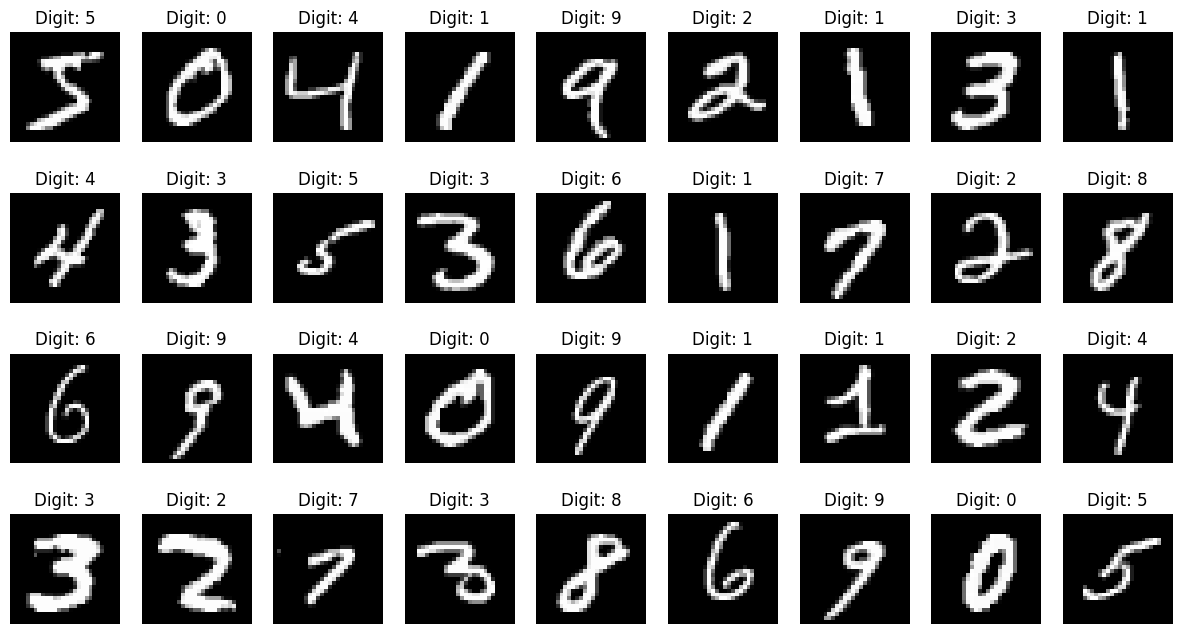

In [7]:
images(train_data)

### `Creating Batches`

In [5]:
# Convert Data using DataLoader for Training and Testing

trainData = DataLoader(dataset = train_data,
                    batch_size = 128,
                    shuffle = True)

testData = DataLoader(dataset = test_data,
                    batch_size = 128,
                    )

trainDataGPU = DeviceDataLoader(trainData,device)
testDataGPU = DeviceDataLoader(testData,device)

print("Device of Train Data: ",trainDataGPU.device)
print("Device of Test Data: ",testDataGPU.device)

len(trainData),len(testData),len(trainDataGPU),len(testDataGPU)

Device of Train Data:  cuda
Device of Test Data:  cuda


(469, 79, 469, 79)

In [6]:
# Iterate through Data in DataLoader

train_digits,train_label=next(iter(trainData))
test_digits,test_label=next(iter(testData))

len(train_digits),len(train_label),len(test_digits),len(test_label)

(128, 128, 128, 128)

## `Training and Testing Loop`

In [7]:
def training_loop(model:nn.Module,train:DataLoader,test:DataLoader,lossFn:nn.Module,optim:torch.optim,epochs:int,train_loss,test_loss):
    epochs = epochs
    total_train_time = 0
    total_test_time = 0
    for epoch in range(0,epochs):
        start = time.time()
        loss_count=0
        for i,(img,label) in enumerate(train):
            model.train()
            model.to(device)
            label_pred=model(img)
            loss=lossFn(label_pred,label)
            
            loss_count+=loss
            
            optim.zero_grad()
            loss.backward()
            optim.step()
        end = time.time()
        
        total_train_time=total_train_time+(end-start)
        train_loss.append(loss_count/len(train))
        print(f"Epoch: {epoch} | Train Loss: {loss_count/len(train)} | Train Accuracy: {train_accuracy(model,train_data,digits)} | Training Time : {end-start}")
        
        loss_count=0
        start = time.time()
        for i,(img,label) in enumerate(test):
            with torch.inference_mode():
                model.eval()
                model.to(device)
                label_pred=model(img)
                loss=lossFn(label_pred,label)
                loss_count+=loss
        
        test_loss.append(loss_count/len(test))
        end = time.time()
        total_test_time = total_test_time + (end - start)
        print(f"Epoch: {epoch} | Test Loss: {loss_count/len(test)} | Test Accuracy: {test_accuracy(model,test_data,digits)} | Testing Time : {end-start}")
    
    print("Total Train Time: ",total_train_time)
    print("Total Test Time: ",total_test_time)
    return train_loss,test_loss

In [11]:
inp_layers = 28*28
hidd_layers = 32
out_layers = 10

# `NonLinear Model`

In [8]:
class NonLinearModel(nn.Module):
    def __init__(self,inp_layers=28*28,hidd_layers=32,out_layers=10):
        super().__init__()
        
        self.l1=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=inp_layers, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=out_layers),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.l1(x)

In [9]:
model1=NonLinearModel()
model1.to(device)
model1,model1.state_dict()

(NonLinearModel(
   (l1): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=512, bias=True)
     (2): ReLU()
     (3): Linear(in_features=512, out_features=256, bias=True)
     (4): ReLU()
     (5): Linear(in_features=256, out_features=128, bias=True)
     (6): ReLU()
     (7): Linear(in_features=128, out_features=64, bias=True)
     (8): ReLU()
     (9): Linear(in_features=64, out_features=64, bias=True)
     (10): ReLU()
     (11): Linear(in_features=64, out_features=32, bias=True)
     (12): ReLU()
     (13): Linear(in_features=32, out_features=10, bias=True)
     (14): LogSoftmax(dim=1)
   )
 ),
 OrderedDict([('l1.1.weight',
               tensor([[ 0.0128,  0.0202, -0.0041,  ...,  0.0219, -0.0269, -0.0060],
                       [-0.0072, -0.0069, -0.0274,  ..., -0.0015, -0.0314,  0.0264],
                       [ 0.0256, -0.0043, -0.0011,  ..., -0.0268,  0.0017, -0.0309],
                       ...,
                       [ 0.0

## `Loss Function and Optimizer`

In [21]:
loss_optim = []
loss_optim = lossFunction(0.003,model1)

In [22]:
train_loss = []
test_loss = []

## `Training and Testing the model`

In [23]:
train_loss_model0,test_loss_model0 = training_loop(model1,trainDataGPU,testDataGPU,loss_optim[0],loss_optim[2],30,train_loss,test_loss)

Epoch: 0 | Train Loss: 2.3019282817840576 | Train Accuracy: 11.744999885559082 | Training Time : 16.425450801849365
Epoch: 0 | Test Loss: 2.2980921268463135 | Test Accuracy: 11.890000104904175 | Testing Time : 2.4800572395324707
Epoch: 1 | Train Loss: 2.2884602546691895 | Train Accuracy: 22.519999742507935 | Training Time : 13.367119073867798
Epoch: 1 | Test Loss: 2.2549948692321777 | Test Accuracy: 22.7400004863739 | Testing Time : 2.3339948654174805
Epoch: 2 | Train Loss: 1.4891149997711182 | Train Accuracy: 76.45666599273682 | Training Time : 13.164393901824951
Epoch: 2 | Test Loss: 0.7162047028541565 | Test Accuracy: 76.30000114440918 | Testing Time : 1.9548921585083008
Epoch: 3 | Train Loss: 0.5428608059883118 | Train Accuracy: 89.31166529655457 | Training Time : 13.529745101928711
Epoch: 3 | Test Loss: 0.3713594079017639 | Test Accuracy: 89.32999968528748 | Testing Time : 2.0529727935791016
Epoch: 4 | Train Loss: 0.32575568556785583 | Train Accuracy: 92.08833575248718 | Training 

In [25]:
print("Model Training Accuracy: ",train_accuracy(model1,train_data,digits))
print("Model Testing Accuracy",test_accuracy(model1,test_data,digits))

Model Training Accuracy:  99.71666932106018
Model Testing Accuracy 97.53000140190125


### `Random Predictions`

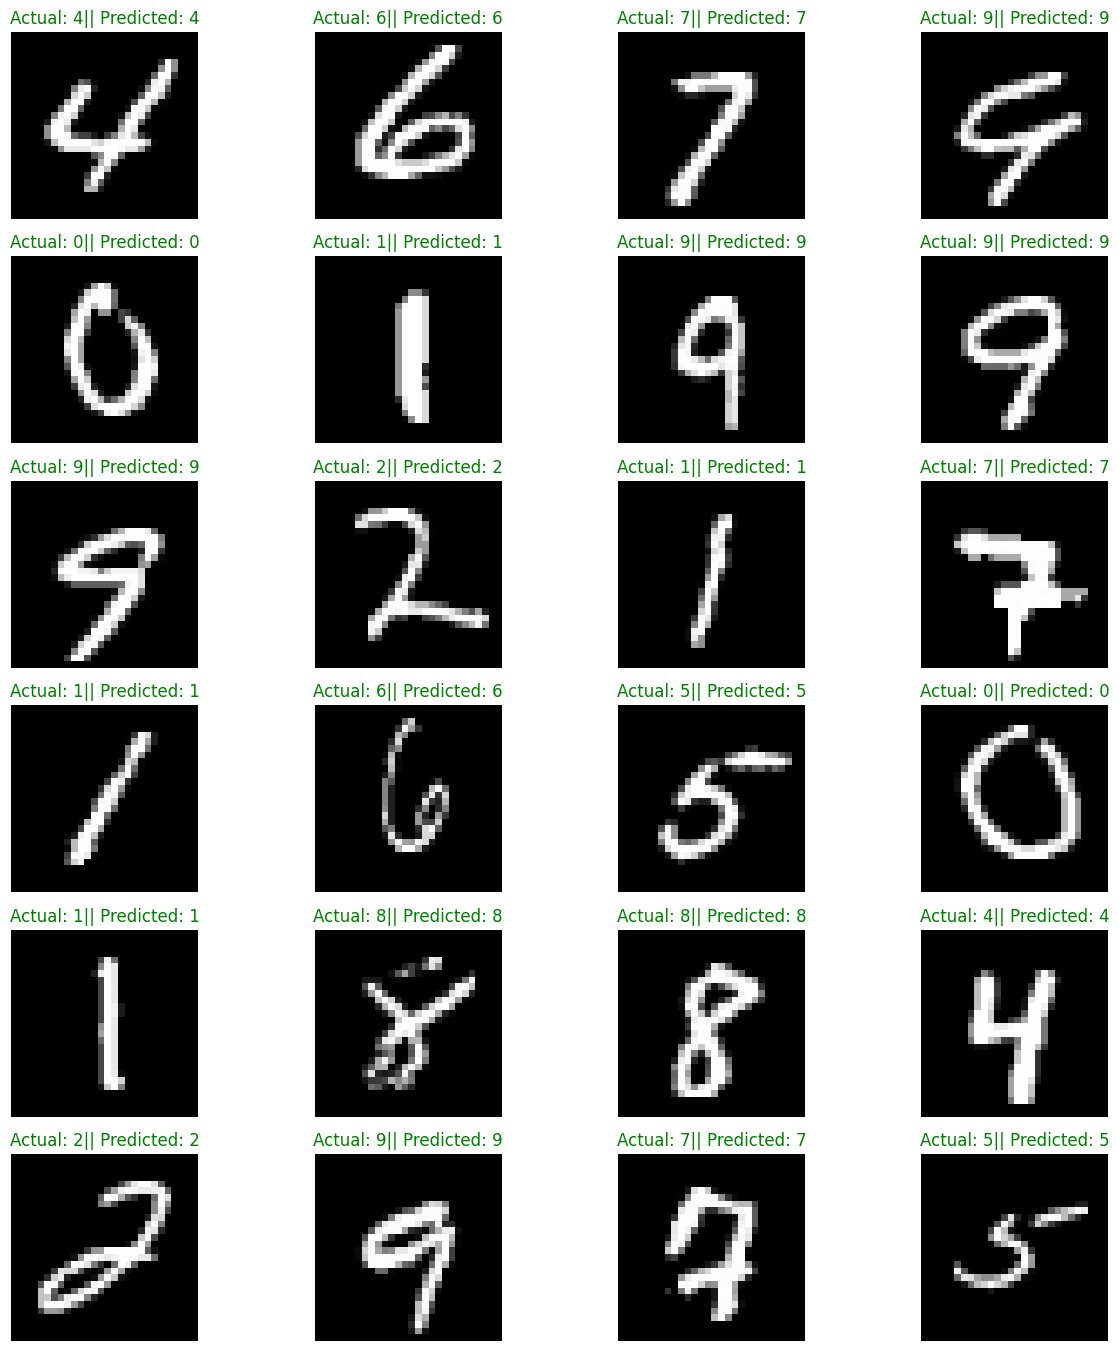

In [26]:
random_pred(model1,test_data)

## `Confusion Matrix`

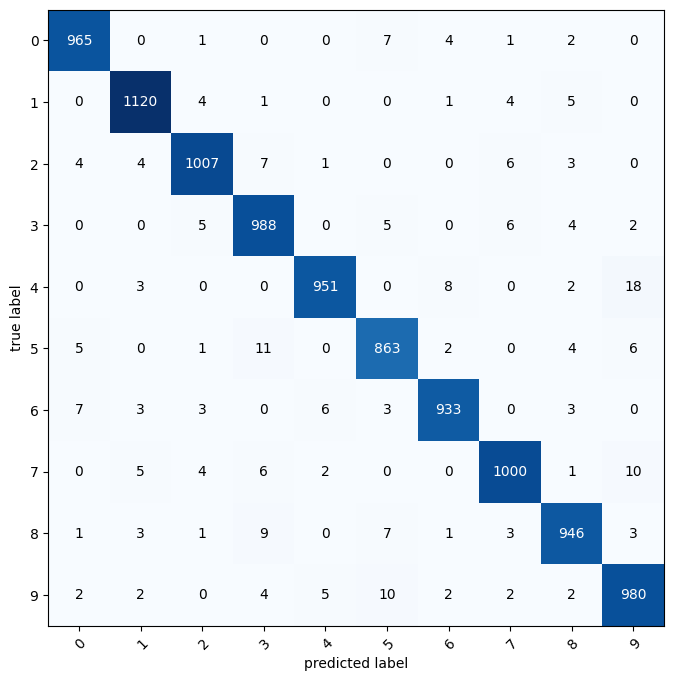

In [27]:
confusion_matrix(model1,test_data,digits)

### `Train and Test Loss Plot`

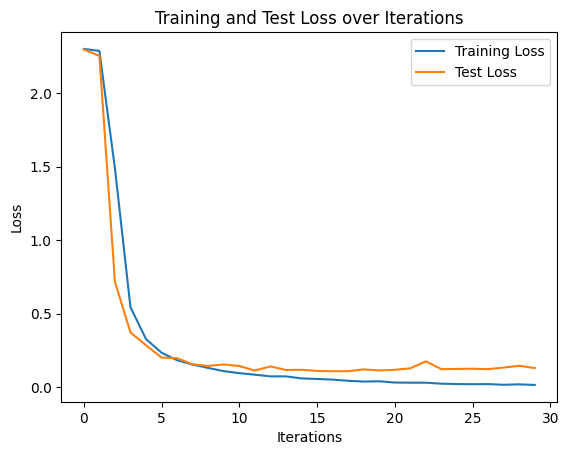

In [28]:
loss_plotting(train_loss,test_loss)

In [29]:
# Saving Our model

torch.save(obj=model1.state_dict(),f="digitclassification97.5300114.pth")

# Experimenting with our Model
# ` For More Accuracy`

In [23]:
modelload = NonLinearModel()
modelload.load_state_dict(torch.load("digitclassification97.5300114.pth"))
modelload.eval()

NonLinearModel(
  (l1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=32, bias=True)
    (12): ReLU()
    (13): Linear(in_features=32, out_features=10, bias=True)
    (14): LogSoftmax(dim=1)
  )
)

In [32]:
loss_optim = []
loss_optim = lossFunction(0.000001,modelload)

In [24]:
print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",test_accuracy(modelload,test_data,digits))

Model Testing Accuracy 97.53000140190125


In [33]:
def training_loop(model:nn.Module,train:DataLoader,test:DataLoader,lossFn:nn.Module,optim:torch.optim,epochs:int,train_loss,test_loss):
    epochs = epochs
    total_train_time = 0
    total_test_time = 0
    for epoch in range(0,epochs):
        start = time.time()
        loss_count=0
        acc_count=0
        for i,(img,label) in enumerate(train):
            model.train()
            model.to(device)
            label_pred=model(img)
            loss=lossFn(label_pred,label)
            # if label_pred[0]==label[0]:
            #     acc_count=acc_count+1
            loss_count+=loss
            
            optim.zero_grad()
            loss.backward()
            optim.step()
        end = time.time()
        
        total_train_time=total_train_time+(end-start)
        train_loss.append(loss_count/len(train))
        #  
        print(f"Epoch: {epoch} | Train Loss: {loss_count/len(train)} | Training Time : {end-start}")
        
        loss_count=0
        acc_count=0
        start = time.time()
        for i,(img,label) in enumerate(test):
            with torch.inference_mode():
                model.eval()
                model.to(device)
                label_pred=model(img)
                # if label_pred==label:
                #     acc_count=acc_count+1
                loss=lossFn(label_pred,label)
                loss_count+=loss
        
        test_loss.append(loss_count/len(test))
        end = time.time()
        total_test_time = total_test_time + (end - start)
        #  
        print(f"Epoch: {epoch} | Test Loss: {loss_count/len(test)} | Testing Time : {end-start}")
    
    print("Total Train Time: ",total_train_time)
    print("Total Test Time: ",total_test_time)
    return train_loss,test_loss

In [28]:
train_loss=[]
test_loss=[]

In [29]:
train_loss_modelload,test_loss_modelload = training_loop(modelload,trainDataGPU,testDataGPU,loss_optim[0],loss_optim[2],10,train_loss,test_loss)

Epoch: 0 | Train Loss: 0.00971599854528904 | Training Time : 42.10375738143921
Epoch: 0 | Test Loss: 0.12868359684944153 | Testing Time : 6.6191816329956055
Epoch: 1 | Train Loss: 0.00971830915659666 | Training Time : 39.90704894065857
Epoch: 1 | Test Loss: 0.12868359684944153 | Testing Time : 9.07979679107666
Epoch: 2 | Train Loss: 0.009727387689054012 | Training Time : 46.212042808532715
Epoch: 2 | Test Loss: 0.12868359684944153 | Testing Time : 6.0640950202941895
Epoch: 3 | Train Loss: 0.00971757061779499 | Training Time : 37.834213972091675
Epoch: 3 | Test Loss: 0.12868359684944153 | Testing Time : 7.711036920547485
Epoch: 4 | Train Loss: 0.009716899134218693 | Training Time : 52.71599197387695
Epoch: 4 | Test Loss: 0.12868359684944153 | Testing Time : 7.190876722335815
Epoch: 5 | Train Loss: 0.009719021618366241 | Training Time : 53.05992650985718
Epoch: 5 | Test Loss: 0.12868359684944153 | Testing Time : 3.573070526123047
Epoch: 6 | Train Loss: 0.009720159694552422 | Training Tim

In [30]:
print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",test_accuracy(modelload,test_data,digits))

Model Training Accuracy:  99.71666932106018
Model Testing Accuracy 97.53000140190125


In [34]:
train_loss_modelload,test_loss_modelload = training_loop(modelload,trainDataGPU,testDataGPU,loss_optim[0],loss_optim[2],15,train_loss,test_loss)

Epoch: 0 | Train Loss: 0.009474934078752995 | Training Time : 19.734203100204468
Epoch: 0 | Test Loss: 0.12769560515880585 | Testing Time : 2.7466726303100586
Epoch: 1 | Train Loss: 0.009028497152030468 | Training Time : 16.852365732192993
Epoch: 1 | Test Loss: 0.1268901228904724 | Testing Time : 2.5090599060058594
Epoch: 2 | Train Loss: 0.008663740009069443 | Training Time : 18.010356426239014
Epoch: 2 | Test Loss: 0.12622202932834625 | Testing Time : 2.5667564868927
Epoch: 3 | Train Loss: 0.00836780946701765 | Training Time : 17.353264093399048
Epoch: 3 | Test Loss: 0.12567327916622162 | Testing Time : 2.8079440593719482
Epoch: 4 | Train Loss: 0.008129661902785301 | Training Time : 18.49191975593567
Epoch: 4 | Test Loss: 0.12520959973335266 | Testing Time : 2.7717392444610596
Epoch: 5 | Train Loss: 0.007908825762569904 | Training Time : 19.37674593925476
Epoch: 5 | Test Loss: 0.12480055540800095 | Testing Time : 2.612398862838745
Epoch: 6 | Train Loss: 0.007724246475845575 | Training

In [35]:
acc=test_accuracy(modelload,test_data,digits)
print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",acc)
# Saving Our model

torch.save(obj=modelload.state_dict(),f=f"digitclassification{acc}.pth")

Model Training Accuracy:  99.82333183288574
Model Testing Accuracy 97.61999845504761


In [36]:
train_loss_modelload,test_loss_modelload = training_loop(modelload,trainDataGPU,testDataGPU,loss_optim[0],loss_optim[2],20,train_loss,test_loss)

Epoch: 0 | Train Loss: 0.0066750142723321915 | Training Time : 17.412742853164673
Epoch: 0 | Test Loss: 0.1224401593208313 | Testing Time : 2.2995047569274902
Epoch: 1 | Train Loss: 0.0065922848880290985 | Training Time : 19.789936065673828
Epoch: 1 | Test Loss: 0.1222868487238884 | Testing Time : 2.645655393600464
Epoch: 2 | Train Loss: 0.00651678116992116 | Training Time : 15.068408489227295
Epoch: 2 | Test Loss: 0.12214728444814682 | Testing Time : 2.2717463970184326
Epoch: 3 | Train Loss: 0.006440161261707544 | Training Time : 15.690534114837646
Epoch: 3 | Test Loss: 0.1220073401927948 | Testing Time : 2.2845425605773926
Epoch: 4 | Train Loss: 0.00636921264231205 | Training Time : 19.521012783050537
Epoch: 4 | Test Loss: 0.12188075482845306 | Testing Time : 2.3809146881103516
Epoch: 5 | Train Loss: 0.006301994435489178 | Training Time : 16.46480107307434
Epoch: 5 | Test Loss: 0.12175489217042923 | Testing Time : 3.5923056602478027
Epoch: 6 | Train Loss: 0.006238891743123531 | Train

In [37]:
acc=test_accuracy(modelload,test_data,digits)
print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",acc)

Model Training Accuracy:  99.86833333969116
Model Testing Accuracy 97.67000079154968


In [38]:
# Saving Our model

torch.save(obj=modelload.state_dict(),f=f"digitclassification{acc}.pth")

In [ ]:
loss_optim = []
loss_optim = lossFunction(0.000001,modelload)

In [ ]:
train_loss_modelload,test_loss_modelload = training_loop(modelload,trainDataGPU,testDataGPU,loss_optim[0],loss_optim[2],25,train_loss,test_loss)

Epoch: 0 | Train Loss: 0.002342584077268839 | Training Time : 17.091671466827393
Epoch: 0 | Test Loss: 0.11934974789619446 | Testing Time : 2.959092617034912
Epoch: 1 | Train Loss: 0.0023410972207784653 | Training Time : 15.528906345367432
Epoch: 1 | Test Loss: 0.11935188621282578 | Testing Time : 2.4190804958343506
Epoch: 2 | Train Loss: 0.0023414716124534607 | Training Time : 15.440641641616821
Epoch: 2 | Test Loss: 0.11935340613126755 | Testing Time : 2.367954730987549
Epoch: 3 | Train Loss: 0.0023414907045662403 | Training Time : 15.533543348312378
Epoch: 3 | Test Loss: 0.11935622990131378 | Testing Time : 2.406165838241577
Epoch: 4 | Train Loss: 0.002338627353310585 | Training Time : 15.49513554573059
Epoch: 4 | Test Loss: 0.1193573921918869 | Testing Time : 2.400029182434082
Epoch: 5 | Train Loss: 0.00233853398822248 | Training Time : 15.655487775802612
Epoch: 5 | Test Loss: 0.11936010420322418 | Testing Time : 2.505655527114868
Epoch: 6 | Train Loss: 0.002337949350476265 | Train

In [ ]:
acc=test_accuracy(modelload,test_data,digits)
print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",acc)

# Saving Our model

torch.save(obj=modelload.state_dict(),f=f"digitclassification{acc}.pth")

Model Training Accuracy:  99.97666478157043
Model Testing Accuracy 97.69999980926514


In [ ]:
loss_optim = []
loss_optim = lossFunction(0.00001,modelload)

In [ ]:
acc=test_accuracy(modelload,test_data,digits)
print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",acc)

# Saving Our model

torch.save(obj=modelload.state_dict(),f=f"digitclassification{acc}.pth")

In [45]:
modelload1 = NonLinearModel()
modelload1.load_state_dict(torch.load("digitclassification97.67000079154968.pth"))
modelload1.eval()

acc=test_accuracy(modelload1,test_data,digits)
# print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",acc)

Model Testing Accuracy 97.67000079154968


In [46]:
loss_optim = []
loss_optim = lossFunction(0.00000001,modelload1)

In [47]:
train_loss_modelload,test_loss_modelload = training_loop(modelload1,trainDataGPU,testDataGPU,loss_optim[1],loss_optim[2],20,train_loss,test_loss)

Epoch: 0 | Train Loss: 0.005532079376280308 | Training Time : 17.064531326293945
Epoch: 0 | Test Loss: 0.12049829959869385 | Testing Time : 2.703644275665283
Epoch: 1 | Train Loss: 0.005529346410185099 | Training Time : 16.19062852859497
Epoch: 1 | Test Loss: 0.12049821019172668 | Testing Time : 2.3531417846679688
Epoch: 2 | Train Loss: 0.0055277482606470585 | Training Time : 17.751005172729492
Epoch: 2 | Test Loss: 0.12049814313650131 | Testing Time : 3.4952683448791504
Epoch: 3 | Train Loss: 0.005528782028704882 | Training Time : 17.430866956710815
Epoch: 3 | Test Loss: 0.12049810588359833 | Testing Time : 2.259963035583496
Epoch: 4 | Train Loss: 0.005527940578758717 | Training Time : 15.033226728439331
Epoch: 4 | Test Loss: 0.12049803137779236 | Testing Time : 2.699155807495117
Epoch: 5 | Train Loss: 0.005528508219867945 | Training Time : 16.82783579826355
Epoch: 5 | Test Loss: 0.12049797177314758 | Testing Time : 2.615530490875244
Epoch: 6 | Train Loss: 0.005545330699533224 | Train

In [48]:
acc=test_accuracy(modelload1,test_data,digits)
# print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",acc)

Model Testing Accuracy 97.67000079154968


In [49]:
loss_optim = []
loss_optim = lossFunction(0.000001,modelload1)

#### Used crossenthropy loss

In [50]:
train_loss_modelload,test_loss_modelload = training_loop(modelload1,trainDataGPU,testDataGPU,loss_optim[1],loss_optim[2],100,train_loss,test_loss)

Epoch: 0 | Train Loss: 0.005511326249688864 | Training Time : 16.342331171035767
Epoch: 0 | Test Loss: 0.12042903900146484 | Testing Time : 3.8761515617370605
Epoch: 1 | Train Loss: 0.00546984700486064 | Training Time : 20.19866418838501
Epoch: 1 | Test Loss: 0.1203627660870552 | Testing Time : 2.935073137283325
Epoch: 2 | Train Loss: 0.005436231382191181 | Training Time : 17.353235960006714
Epoch: 2 | Test Loss: 0.12029954791069031 | Testing Time : 2.3958823680877686
Epoch: 3 | Train Loss: 0.0054000974632799625 | Training Time : 16.560343980789185
Epoch: 3 | Test Loss: 0.12023789435625076 | Testing Time : 2.8177971839904785
Epoch: 4 | Train Loss: 0.005353762302547693 | Training Time : 18.785370349884033
Epoch: 4 | Test Loss: 0.12017595767974854 | Testing Time : 2.49357008934021
Epoch: 5 | Train Loss: 0.0053171725012362 | Training Time : 16.656004428863525
Epoch: 5 | Test Loss: 0.1201145350933075 | Testing Time : 2.359541654586792
Epoch: 6 | Train Loss: 0.005278967786580324 | Training 

In [51]:
acc=test_accuracy(modelload1,test_data,digits)
print("Model Training Accuracy: ",train_accuracy(modelload,train_data,digits))
print("Model Testing Accuracy",acc)

Model Training Accuracy:  99.86833333969116
Model Testing Accuracy 97.75000214576721


In [53]:
# Saving Our model

torch.save(obj=modelload1.state_dict(),f=f"digitclassification{acc}.pth")

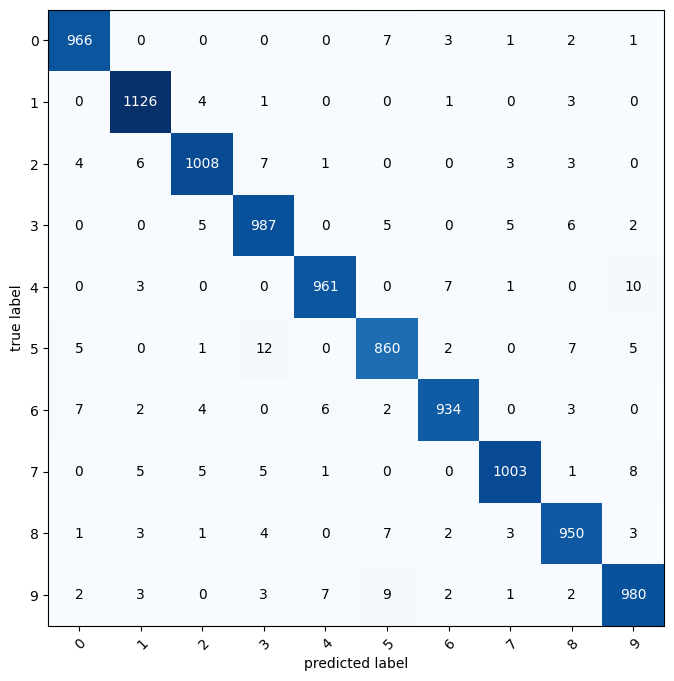

In [54]:
confusion_matrix(modelload1,test_data,digits)

#### Final Train Accuracy: `99.81`
#### Final Test Accuracy: `97.75`